# House Prices Regression 

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Notes for later:
remove the SalePrice in the Test Dataset

In [64]:
df_train = pd.read_csv("train.csv",index_col = 'Id')
df_test = pd.read_csv("test.csv", index_col = 'Id')

We concatenate test and training dataset to perform all actions on both datasets at the same time. Later we can separate them again according to the introduced variable Training Set.

In [65]:
df_train["Training Set"] = 1
df_test["Training Set"] = 0
df = pd.concat([df_train,df_test],axis = 0, sort = False)

In [66]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Training Set
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


In [67]:
df.describe()
df.shape

(2919, 81)

In [68]:
#Check how many values are nulls
df.isnull().sum()[df.columns[df.isnull().sum()>0]]


MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

In [69]:
#We drop all variables that have >50 percent NAs
df = df.drop(axis = 1, labels = ['Alley','PoolQC','Fence','MiscFeature'])
df.shape
#in a later stage we might check whether we want to keep Alley, as NA tells us that there is no alley access

(2919, 77)

In [70]:
#FireplaceQu is Fireplace Quality. It is NA if no fireplace is available. That can be confusing, lets just change it to 'no'
df['FireplaceQu']=df['FireplaceQu'].fillna('No')


In [71]:
#For the moment, we will handle the replacement of missing values as simple as possible
#LotFrontage is handled by mean of all observation 
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].mean())
df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].mean())
#categorical variables will be handled by their variable's mode
df['Electrical']=df['Electrical'].fillna(df['Electrical'].mode()[0])
df['MasVnrType']=df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
#We will not change anything about Garage variables, as GarageType = NA if no garage is available. If we would change this by replacing NAs, we would distort the data set
#The same applies to Bsmt variables 

(2919, 77)

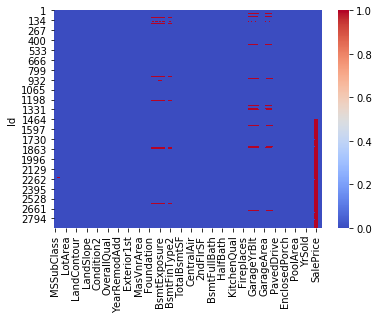

In [72]:
sns.heatmap(df.isnull(),cmap='coolwarm')
df.shape

In [73]:
#We filter for categorical features to be able to adjust them
#https://datatofish.com/convert-pandas-dataframe-to-list/
df_objectcolumns = df.select_dtypes(include = 'object')
varlist = df_objectcolumns.columns.values.tolist()
varlist

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [74]:
#We create dummy variables for all categorical variables
final_df = df
final_df = pd.get_dummies(df,columns = varlist, drop_first = True)

In [75]:
final_df.shape

(2919, 239)

In [76]:
#Now we separate Test and Training dataset again. As Test does not have values for SalePrice, we drop it as well. 
df_train = final_df[final_df['Training Set'] == 1]
df_train.drop(labels = ['Training Set'], axis = 1, inplace = True)
df_test = final_df[final_df['Training Set'] == 0]
df_test.drop(labels = ['SalePrice','Training Set'], axis =1, inplace = True)

# Model Formulation and Execution.

We use Gradient Boosting for regression in the first step


In [77]:
X_train = df_train.drop('SalePrice',axis = 1)
y_train = df_train['SalePrice']

In [78]:
import xgboost
classifier = xgboost.XGBRegressor()
classifier.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=8, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [79]:
y_pred = classifier.predict(df_test)

In [82]:
y_pred

array([123525.99, 155754.1 , 181717.77, ..., 185456.94, 114746.53,
       209754.94], dtype=float32)

Formatting for the submission file

In [86]:
pred = pd.DataFrame(y_pred)
sub_df = pd.read_csv('sample_submission.csv')
datasets = pd.concat([sub_df['Id'],pred], axis = 1)
datasets.columns = ['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index = False)

This results in a RMSE of 0.13988 for my first submission. 